In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [16]:
# Load your dataset
data = pd.read_csv('input_file.csv',encoding='latin-1',low_memory=False)

In [17]:
def target_var_binary(df):
    if df['Likely_to_recommend_Online_Site_MY_SITE'] >= 6:
        val = 1
    elif df['Likely_to_recommend_Online_Site_MY_SITE'] < 6:
        val = 0
    return val

data['my_site_recommend'] = data.apply(target_var_binary, axis=1)
data = data.drop(['Date_Replied','Control_Count','Status','Likely_to_recommend_Online_Site_MY_SITE'], axis=1)

In [18]:
# Separate features and target
X = data.drop('my_site_recommend', axis=1)
y = data['my_site_recommend']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Impute missing values
# For numerical columns
num_imputer = SimpleImputer(strategy='median')
X_train_num = num_imputer.fit_transform(X_train.select_dtypes(exclude=['object']))
X_test_num = num_imputer.transform(X_test.select_dtypes(exclude=['object']))

# For categorical columns
cat_imputer = SimpleImputer(strategy='most_frequent')
X_train_cat = cat_imputer.fit_transform(X_train.select_dtypes(include=['object']))
X_test_cat = cat_imputer.transform(X_test.select_dtypes(include=['object']))

# Encode categorical variables
onehot_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_train_cat_encoded = onehot_encoder.fit_transform(X_train_cat)
X_test_cat_encoded = onehot_encoder.transform(X_test_cat)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [19]:
# Scale the numerical features
scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train_num)
X_test_num_scaled = scaler.transform(X_test_num)

# Combine numerical and categorical features
X_train_processed = np.hstack((X_train_num_scaled, X_train_cat_encoded))
X_test_processed = np.hstack((X_test_num_scaled, X_test_cat_encoded))

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_processed, y_train)

LogisticRegression(max_iter=1000)

In [20]:
# Predictions
y_train_pred = log_reg.predict(X_train_processed)
y_test_pred = log_reg.predict(X_test_processed)

# Performance Evaluation
## Training Set
print("Training Set Evaluation:\n")
print(classification_report(y_train, y_train_pred))

Training Set Evaluation:

              precision    recall  f1-score   support

           0       0.74      0.38      0.51      2459
           1       0.72      0.92      0.81      4309

    accuracy                           0.73      6768
   macro avg       0.73      0.65      0.66      6768
weighted avg       0.73      0.73      0.70      6768



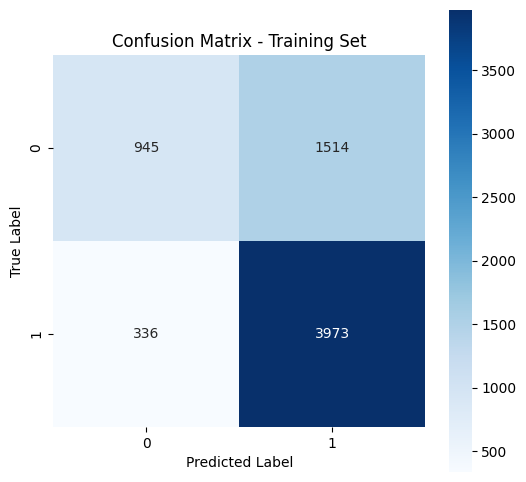

In [21]:
# Confusion Matrix for the Training Set
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
plt.figure(figsize=(6,6))
sns.heatmap(conf_matrix_train, annot=True, fmt='d', cmap='Blues', square=True)
plt.title('Confusion Matrix - Training Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [22]:
## Test Set
print("Test Set Evaluation:\n")
print(classification_report(y_test, y_test_pred))

Test Set Evaluation:

              precision    recall  f1-score   support

           0       0.76      0.38      0.50       642
           1       0.71      0.93      0.80      1050

    accuracy                           0.72      1692
   macro avg       0.73      0.65      0.65      1692
weighted avg       0.73      0.72      0.69      1692



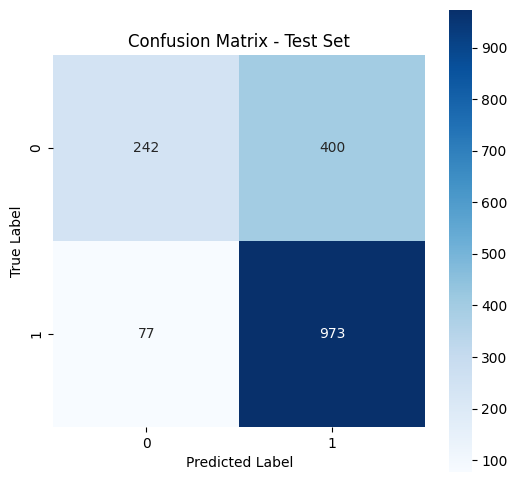

In [23]:
# Confusion Matrix for the Test Set
conf_matrix_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6,6))
sns.heatmap(conf_matrix_test, annot=True, fmt='d', cmap='Blues', square=True)
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [24]:
# Function to plot ROC Curve
def plot_roc_curve(y_true, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

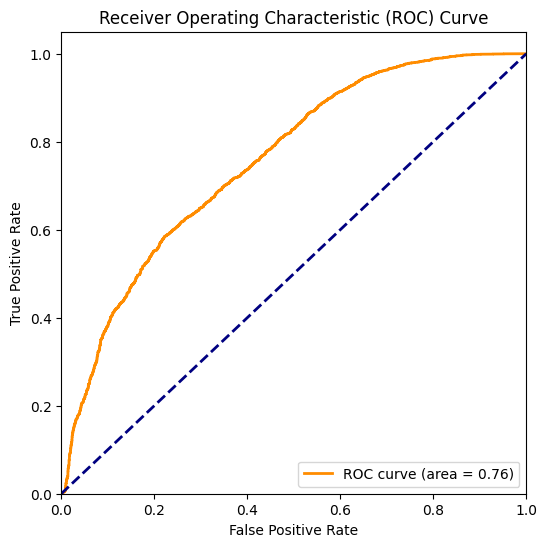

In [25]:
# ROC Curve for Training Set
y_train_pred_proba = log_reg.predict_proba(X_train_processed)[:, 1]
plot_roc_curve(y_train, y_train_pred_proba)

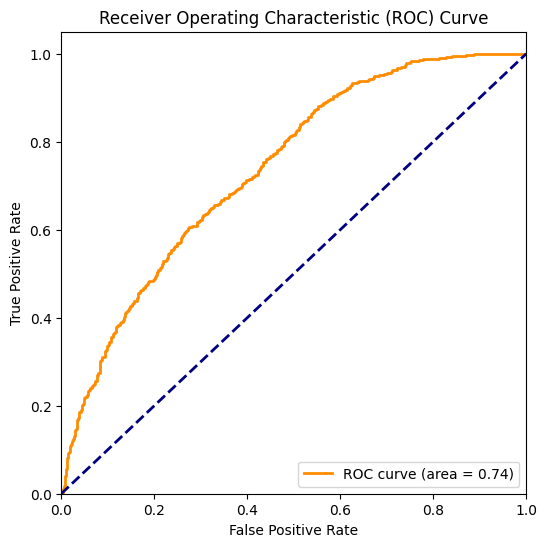

In [26]:
# ROC Curve for Test Set
y_test_pred_proba = log_reg.predict_proba(X_test_processed)[:, 1]
plot_roc_curve(y_test, y_test_pred_proba)